# STAT 201 Project Proposal

## A Look into Salaries and Remote Work in the Data Science Field

### Ryan Arnouk, Amy Chen, Reuben John, Youssef Saleh

## Introduction

### Background

Monetary compensation is a one of the key factors in employee satisfaction (Card et al., 2012), and studies have shown that working remotely has also positively impacted satisfaction during the pandemic, due to increased autonomy (Galanti et al., 2021).

Based on these two facts, this report aims to provide information regarding salaries and the likelihood of working remotely for each type of job, to people entering the data science job market. This would help them find jobs that match their own hopes and aspirations, as well as create a work environment that is productive in and out of the workplace by influencing work-life balance.

### Guiding Question
> Comparing full-time Data Analysts and Data Engineers, is there a *difference in means* of salaries and *difference in proportions* of remote work?

### Dataset

In this project, we use the dataset, "Data Science Job Salaries", by Ruchi Bhatia (2022) from [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries). It contains both qualitative and quantitative observations we can harness, like the year the salary was paid, experience level, employment type, title, salary, remote ratio, company size, and company location.

From this dataset, our variables of interest are as follows:
* ```salary_in_usd``` is our response variable, it uses a single currency (USD) to make comparisons easier regardless of country.
* ```job_title``` is one of our explanatory variables; a ```chr``` describing each employee's profession.
* ```remote_ratio``` is another explanatory variable; a ```fct``` describing each employee's ratio of remote work (0 = less than 20%, 50 = in between, 100 = greater than 80%)

While ```experience_level``` does affect salary, this project is aimed at helping potential employees choose a job, and their own experience level is not something they can select for when job hunting.

Together, these variables can help us achieve a more complete picture of the job market in the Data Science field.

## Preliminary Results

### Reading the Data

Kaggle does not allow datasets to be read directly from the website, so we downloaded the data to our repository and read it from there.

In [98]:
library(tidyverse)
library(infer)
library(broom)
library(gridExtra)
library(scales)

set.seed(1234)

# reading the data
salaries <- read.csv("https://raw.githubusercontent.com/ryanarnouk/stat-201-project/main/ds_salaries.csv") %>%
     select(!X) # index column

# preview the data
head(salaries)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
2,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
3,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
4,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
5,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
6,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


### Cleaning and Wrangling Data

This dataset contains a lot of ```job_title``` categories, so let's see which ones we can work with.

In [48]:
# calculating the number of employees in each job title category
salaries %>% 
    filter(employment_type == "FT") %>% # filtering for full-time employees
    group_by(job_title) %>%
    summarise(n = n()) %>%
    arrange(-n) %>% # so most frequent jobs come up first
    head()

job_title,n
<chr>,<int>
Data Scientist,140
Data Engineer,129
Data Analyst,96
Machine Learning Engineer,41
Research Scientist,16
Data Science Manager,12


Here we can see that the first four categories each have more than 30 observations, meaning they are large enough. Of those categories, Data Engineers and Machine Learning Engineers seem to be comparable roles.

Let's grab only those categories and store them in a dataframe named ```top_jobs```.

In [54]:
# filtering for full-time employees from both categories
eng_jobs <- salaries %>%
    filter(employment_type == "FT",
           job_title %in% c("Data Engineer", "Machine Learning Engineer")) %>%
    mutate(remote_ratio = recode(remote_ratio, `0` = "in_person", `50` = "hybrid", `100` = "remote"),
          is_remote = remote_ratio == "remote") %>%
    select(job_title, is_remote, salary_in_usd) # more readable

head(eng_jobs)

,job_title,is_remote,salary_in_usd
,<chr>,<lgl>,<int>
1,Machine Learning Engineer,FALSE,150000
2,Data Engineer,TRUE,41689
3,Machine Learning Engineer,FALSE,43331
4,Data Engineer,FALSE,47899
5,Data Engineer,FALSE,33511
6,Data Engineer,FALSE,74130


### Plots

#### Salary distributions

First, let's look at the distributions of salaries in each of the categories by plotting them side-by-side.
We will also add red vertical lines to show their mean salaries.

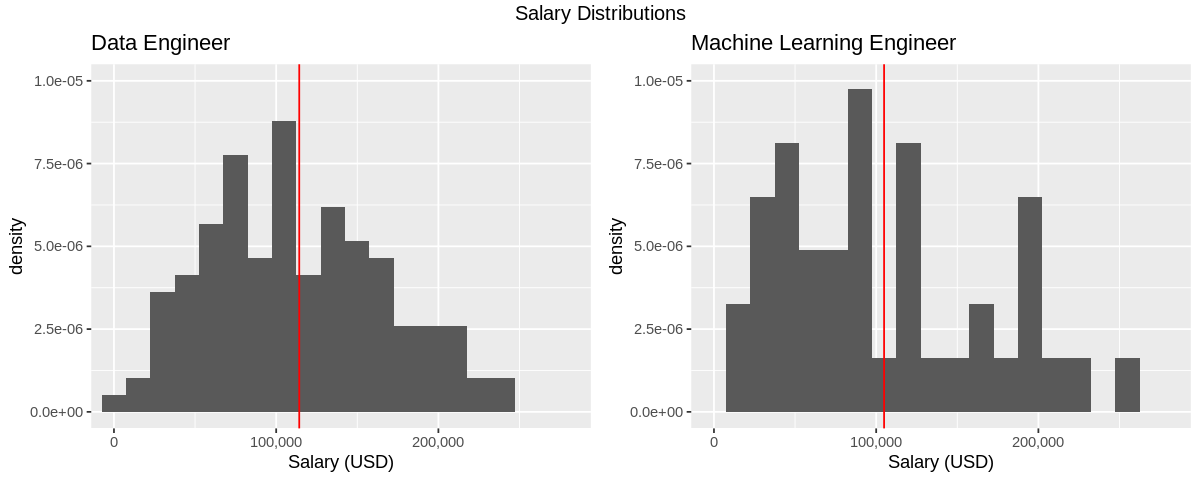

In [55]:
options(repr.plot.width = 10, repr.plot.height = 4) # setting dimensions

deng_dist <- eng_jobs %>% # data engineer distribution
    filter(job_title == "Data Engineer") %>%
    ggplot(aes(x = salary_in_usd, y = ..density..)) +
    geom_histogram(binwidth = 15000) +
    geom_vline(xintercept = mean(filter(top_jobs, job_title == "Data Engineer")$salary_in_usd),
              color = "red") +
    labs(x = "Salary (USD)", title = "Data Engineer") +
    scale_x_continuous(labels = comma) +  # so salaries aren't in scientific notation
    coord_cartesian(xlim = c(0, 280000), ylim = c(0, 1e-05)) # same width x-axes
                                                                # this cuts off some outlier data

mlen_dist <- eng_jobs %>% # machine learning engineer distribution
    filter(job_title == "Machine Learning Engineer") %>%
    ggplot(aes(x = salary_in_usd, y = ..density..)) +
    geom_histogram(binwidth = 15000) +
    geom_vline(xintercept = mean(filter(top_jobs, job_title == "Machine Learning Engineer")$salary_in_usd),
              color = "red") +
    labs(x = "Salary (USD)", title = "Machine Learning Engineer") +
    scale_x_continuous(labels = comma) + # so salaries aren't in scientific notation
    coord_cartesian(xlim = c(0, 280000), ylim = c(0, 1e-05)) # same width x-axes

grid.arrange(deng_dist, mlen_dist, ncol = 2, top = "Salary Distributions")

### Estimates

Before testing our hypotheses, we need to have the appropriate point estimates.

In [57]:
eng_est <- eng_jobs %>%
    group_by(job_title) %>%
    summarize(n = n(), # number of observations
              mean_salary = mean(salary_in_usd), # mean salary
              sd_salary = sd(salary_in_usd), # standard deviation of salaries
              prop_remote = mean(is_remote)) # proportion of remote work

head(eng_est)

job_title,n,mean_salary,sd_salary,prop_remote
<chr>,<int>,<dbl>,<dbl>,<dbl>
Data Engineer,129,114224.8,57349.85,0.7131783
Machine Learning Engineer,41,104880.1,63218.63,0.5365854


**Note**: Although the median is a better estimate for salaries, this project relies on CLT, which dictates that we use the mean instead.

## Methods

### Plan

So far, this report has indicated that the mean salaries earned by Data Engineers and Machine Learning Engineers are different, as well as their proportion of employees working remotely. We used representative samples (with n > 30), and have narrowed it down to full-time employees, so that the response variables are truly random and not based on employment type.

Our plots and point estimates are not enough to prove that, because they use only one sample, meaning they are more prone to error compared to a *sampling* distribution. To remedy this, we will use resampling and asymptotic methods to model the population distributions.

Since we do not have the populations' true means $\mu$, proportions $p$, and standard deviations $\sigma$, we will use the sample means $\bar{x}$, proportions $\hat{p}$, and standard deviations $s$. To account for the risk of error associated with this substitution, we will use $t$-distributions because of their thicker tails and wider spread, as compared to a standard distribution.

We will also perform bootstrapping on both samples, getting the distribution of salary standard deviations and remote work standard deviations for each sample.

By letting Data Engineers be population 1, and Machine Learning Engineers be population 2, we aim to test the following hypotheses:

for the mean salary:
$$H_0 : \mu_1 - \mu_2 = 0$$
$$H_1 : \mu_1 - \mu_2 \neq 0$$

for the proportion of remote work:
$$H_0 : p_1 - p_2 = 0$$
$$H_1 : p_1 - p_2 \neq 0$$

where $\mu$ is the population's mean salary and $p$ is its proportion of employees working remotely. Our $t$-distributions will therefore be $t_{128}$ and $t_{95}$ respectively.

We expect to reject both null hypotheses under a 5% significance level, with a 90% confidence level.

## Results

### Resampling method

First, we will use the ```infer``` package to model our null distribution. For this, we will generate 10000 resamples and calculate the difference in means.

In [96]:
set.seed(1234)

salary_sd_bootstrap <- eng_jobs %>%
    rep_sample_n(size = nrow(eng_jobs), reps = 10000, replace = TRUE) %>%
    group_by(replicate, job_title) %>%
    summarize(sd = sd(salary_in_usd))

head(salary_sd_bootstrap)

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,job_title,sd
<int>,<chr>,<dbl>
1,Data Engineer,58435.92
1,Machine Learning Engineer,69683.77
2,Data Engineer,49737.96
2,Machine Learning Engineer,59728.73
3,Data Engineer,50687.93
3,Machine Learning Engineer,58103.73


job_title,lower_ci,higher_ci
<chr>,<dbl>,<dbl>
Data Engineer,50763.86,63461.11
Machine Learning Engineer,52750.46,71306.77


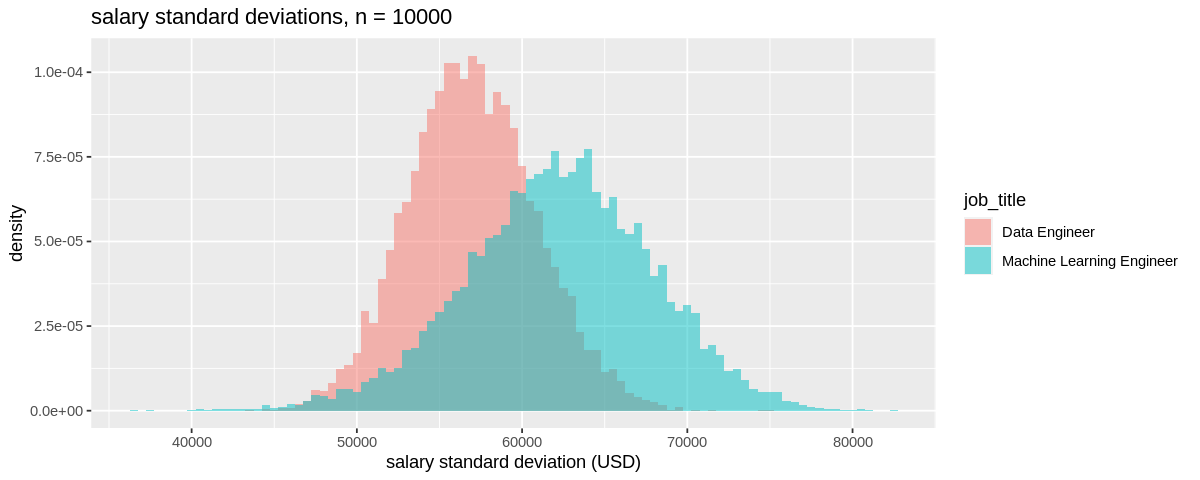

In [97]:
conf_int <- salary_sd_bootstrap %>%
    group_by(job_title) %>%
    summarize(lower_ci = quantile(sd, 0.05), higher_ci = quantile(sd, 0.95))

conf_int


salary_sd_bootstrap_dist <- salary_sd_bootstrap %>%
    ggplot(aes(x = sd, y = ..density.., fill = job_title)) +
    geom_histogram(binwidth = 500, position = "identity", alpha = 0.5) +
    labs(x = "salary standard deviation (USD)", title = "salary standard deviations, n = 10000")
    

salary_sd_bootstrap_dist

### Asymptotic method

For our asymptotic method, we will be running $t$-tests for each of the null hypotheses, using the ```t.test()``` function

In [20]:
mean_t_test <- t.test(x = filter(anst_engr, job_title == "Data Engineer")$salary_in_usd,
           y = filter(anst_engr, job_title == "Data Analyst")$salary_in_usd, 
           alternative = "two.sided", paired = FALSE, conf.level = 0.90) %>%
    tidy() %>%
    select(p.value, conf.low, conf.high)

mean_t_test

p.value,conf.low,conf.high
<dbl>,<dbl>,<dbl>
0.001706161,9824.761,31119.2


The $p$-value 0.17% is significantly lower than the significance level, so **we have enough evidence to reject $H_0$**, we can also be **90% confident that the average Data Engineer earns \\$9800 to \\$31000 more than the average Data Analyst**.

In [12]:
prop_t_test <- t.test(x = filter(anst_engr, job_title == "Data Engineer")$is_remote,
           y = filter(anst_engr, job_title == "Data Analyst")$is_remote, 
           alternative = "two.sided", paired = FALSE, conf.level = 0.90) %>%
    tidy() %>%
    select(p.value, conf.low, conf.high)

prop_t_test

p.value,conf.low,conf.high
<dbl>,<dbl>,<dbl>
0.7922944,-0.1161767,0.08419995


The $p$-value is 79%, which is much higher than our significance level of 5%. Therefore, **we do not have enough evidence to reject $H_0$**.

### ANOVA

In [13]:
anova <- aov(salary_in_usd~is_remote, data = anst_engr) %>% 
tidy() %>%
select(statistic, p.value) %>%
filter(!is.na(statistic))

anova

statistic,p.value
<dbl>,<dbl>
11.47507,0.0008337178


## Discussion

### Impact

These findings could impact how new data science graduates choose what jobs to apply for, as well as what specific career paths undergraduates may wish to focus on.

### Future

This opens the door for further questions about the difference in experience level, company location and company size when comparing different job titles within the Data Science field. Also, with more data, these questions can be answered for the rest of the jobs that we could not examine due to their sample sizes and distributions.

## References

Card, D., Mas, A., Moretti, E., & Saez, E. (2012). Inequality at work: The effect of peer salaries on job satisfaction. *American Economic Review*, 102(6), 2981–3003. https://doi.org/10.1257/aer.102.6.2981

Galanti, T., Guidetti, G., Mazzei, E., Zappalà, S., & Toscano, F. (2021). Work from home during the COVID-19 outbreak: the impact on employees' remote work productivity, engagement, and stress. *Journal of Occupational and Environmental Medicine*, 63(7), e426–e432. https://doi.org/10.1097/JOM.0000000000002236

Bhatia, R. (2022). *Data science job salaries*. \[Dataset\] https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries